In [1]:
import os

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17504398570367115282
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6709723791
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2507504436574865562
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [3]:
HEIGHT = 28 # Height of the image
WIDTH = 28 # Width of the image
CHANNELS = 1 # Number of channels for an image

Z_DIM = 100 # Dimensions of noise vector z
BATCH_SIZE = 128 # Batch size for training

D_LEARNING_RATE = 2e-4
G_LEARNING_RATE = 2e-4
N_EPOCHS = 300
BETA1 = 0.5
G_ITERS = 1
RUN_NAME = f"vanilla_NO_BN_d_lr{D_LEARNING_RATE}_g_lr{G_LEARNING_RATE}_{BETA1}_{G_ITERS}_{N_EPOCHS}"
SAVE_PATH = None

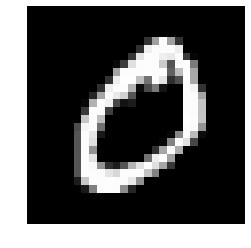

In [4]:
image_dir = 'C:\\Users\\Jonathan\\Documents\\development\\datasets\\images\\mnist\\training'
image_list = []
for directory in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
    for root, d, files in os.walk(os.path.join(image_dir, directory)):
        for file in files:
            if file.endswith('.png'):
                image_list.append(os.path.join(directory, file))

plt.imshow(cv2.imread(os.path.join(image_dir, image_list[0])))
plt.axis('off')
plt.show()

In [5]:
def make_grid(images, rows=8, cols=8):
    grid = np.zeros([images.shape[1] * rows, images.shape[2] * cols])
    
    if rows * cols > images.shape[0]:
        return
    
    i = 0
    for y in range(0, grid.shape[0], images.shape[1]):
        for x in range(0, grid.shape[1], images.shape[2]):
            grid[y:y+images.shape[1], x:x + images.shape[2]] = images[i]
            i += 1
    return grid

def plot_images(images, rows=8, cols=8):
    grid = make_grid(images, rows, cols)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

In [6]:
image_list = image_list[:59904]
len(image_list) / BATCH_SIZE

468.0

In [7]:
g_layers = [256, HEIGHT * WIDTH]
d_layers = [256, 1]

def inverse_transform(image):
    return ((image + 1.) / 2.).clip(0, 1)

def transform(image):
    return ((image * 2. - 1.)).clip(-1, 1)

def generator(z, layers, training=True, reuse=False):
    with tf.variable_scope("generator", reuse=reuse) as scope:
        for i in range(len(layers) - 1):
            z = tf.layers.dense(z, layers[i], use_bias=True, name=f'g_h{i}')
            z = tf.nn.relu(z)
        
        z = tf.layers.dense(z, layers[-1], use_bias=True, name=f'g_h{len(layers) - 1}')
        z = tf.nn.tanh(z)
        return z
    
def discriminator(x, layers, training=True, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse) as scope:
        for i in range(len(layers) - 1):
            x = tf.layers.dense(x, layers[i], use_bias=True, name=f'd_h{i}')
            x = tf.nn.leaky_relu(x, alpha=0.2)
            
        x = tf.layers.dense(x, layers[-1], use_bias=True, name=f'd_h{len(layers) - 1}')
        return x

In [8]:
def inverse_transform(image):
    return ((image + 1.) / 2.).clip(0, 1)

def transform(image):
    return ((image * 2. - 1.)).clip(-1, 1)

def generator(z, layers, training=True, reuse=False):
    with tf.variable_scope("generator", reuse=reuse) as scope:
        for i in range(len(layers) - 1):
            z = tf.layers.dense(z, layers[i], use_bias=True, 
                                kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev=0.02),
                                name=f'g_h{i}')
            z = tf.nn.relu(z)
        
        z = tf.layers.dense(z, layers[-1], use_bias=True, name=f'g_h{len(layers) - 1}')
        z = tf.nn.tanh(z)
        return z
    
def discriminator(x, layers, training=True, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse) as scope:
        for i in range(len(layers) - 1):
            x = tf.layers.dense(x, layers[i], use_bias=True, 
                                kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev=0.02),
                                name=f'd_h{i}')
            x = tf.nn.leaky_relu(x, alpha=0.2)
            
        x = tf.layers.dense(x, layers[-1], use_bias=True, name=f'd_h{len(layers) - 1}')
        return x

In [9]:
with tf.Graph().as_default() as graph:
    z = tf.placeholder(tf.float32, shape=[None, Z_DIM])
    z_fixed = tf.placeholder(tf.float32, shape=[None, Z_DIM])

    x = tf.placeholder(tf.float32, shape=[None, HEIGHT * WIDTH])
    
    g = generator(z, g_layers, training=True, reuse=False)
    g_fixed = generator(z_fixed, g_layers, training=False, reuse=True)
    real_logits = discriminator(x, d_layers, training=True, reuse=False)
    fake_logits = discriminator(g, d_layers, training=True, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, 
                                                                         labels=tf.ones_like(real_logits)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, 
                                                                         labels=tf.zeros_like(fake_logits)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, 
                                                                    labels=tf.ones_like(fake_logits)))
    
    d_loss = d_loss_real + d_loss_fake
    
    d_loss_real_summary = tf.summary.scalar("d_loss_real", d_loss_real)
    d_loss_fake_summary = tf.summary.scalar("d_loss_fake", d_loss_fake)
    g_loss_summary = tf.summary.scalar("g_loss", g_loss)
    d_loss_summary = tf.summary.scalar("d_loss", d_loss)
    images_summary = tf.summary.image("generated_images", tf.reshape((g_fixed + 1.) / 2., [BATCH_SIZE, HEIGHT, WIDTH, 1]))
    
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if 'discriminator' in var.name]
    g_vars = [var for var in trainable_vars if 'generator' in var.name]
    
    print(d_vars)
    print(g_vars)
    
    d_optim = tf.train.AdamOptimizer(D_LEARNING_RATE, beta1=BETA1)\
                    .minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.AdamOptimizer(G_LEARNING_RATE, beta1=BETA1)\
                    .minimize(g_loss, var_list=g_vars)
    
    d_summary = tf.summary.merge([d_loss_real_summary, d_loss_fake_summary, d_loss_summary])
    g_summary = tf.summary.merge([g_loss_summary, images_summary])
    
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter("./runs/{}".format(RUN_NAME), sess.graph)
    summary_step = 0
    
    if SAVE_PATH:
        saver.restore(sess, SAVE_PATH)
    else:
        init = tf.global_variables_initializer()
        sess.run(init)
    
    z_fixed_input = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM])

    for epoch in range(N_EPOCHS):
        np.random.shuffle(image_list)
        i = 0
        while i < len(image_list):
            x_input = np.zeros([BATCH_SIZE, HEIGHT, WIDTH, CHANNELS])
            for k in range(0, BATCH_SIZE):
                x_input[k] = cv2.imread(
                                os.path.join(image_dir, image_list[i + k])
                                )[:, :, [0]]
            
            x_input = transform(x_input / 255).reshape(BATCH_SIZE, -1)
            z_input = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM])
            
            [_, d_summary_result, d_loss_val, dlrv, dlfv] = sess.run([d_optim, d_summary, d_loss, d_loss_real, d_loss_fake], feed_dict={z: z_input, x: x_input})
            
            for _ in range(G_ITERS):
                [_, g_img, g_summary_result] = sess.run([g_optim, g_fixed, g_summary], feed_dict={z: z_input,
                                                                                                   z_fixed: z_fixed_input,
                                                                                                   x: x_input})                
            if (i % (BATCH_SIZE * 50) == 0):
                writer.add_summary(g_summary_result, summary_step)
                writer.add_summary(d_summary_result, summary_step)
                summary_step += 1
            
            i += BATCH_SIZE
            
        if epoch % 5 == 0:
            plot_images(inverse_transform(g_img.reshape(BATCH_SIZE, HEIGHT, WIDTH)))
            cv2.imwrite(f'./results/{epoch}.jpg', make_grid(inverse_transform(g_img.reshape(BATCH_SIZE, HEIGHT, WIDTH))))

        save_path = saver.save(sess, "./checkpoints/{}".format(RUN_NAME))
        print(f"[Epoch {epoch}/{N_EPOCHS}] -- Saved {save_path}")


AttributeError: module 'tensorflow' has no attribute 'initializer'

In [ ]:
tf.initializers.

In [ ]:
plot_images(x_input.reshape(BATCH_SIZE, HEIGHT, WIDTH))